# BASELINE: Support Vector Machines (SVM)

## 1. Preprocessing

In [3]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import numpy as np

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import pointbiserialr
from sklearn.metrics import make_scorer, recall_score, confusion_matrix
import matplotlib.pyplot as plt



In [4]:
def preprocess_data(
    file='data/wdbc.data',
    corr_threshold=0.3,
    test_size=0.2,
    random_state=42
):
    # -------------------------------------
    # 1) Load dataset and rename columns
    # -------------------------------------
    df = pd.read_csv(file, header=None)
    cols = ["id", "diagnosis"] + [
        f"{feat}_{stat}"
        for stat in ["mean", "se", "worst"]
        for feat in ["radius", "texture", "perimeter", "area",
                     "smoothness", "compactness", "concavity",
                     "concave_points", "symmetry", "fractal_dimension"]
    ]
    df.columns = cols

    # -------------------------------------
    # 2) Numerical encoding for correlation filtering
    # -------------------------------------
    df["diagnosis"] = df["diagnosis"].map({"B": 0.0, "M": 1.0})

    correlated_columns = ["diagnosis"]
    for col in df.drop(columns=["diagnosis", "id"]).columns:
        r, _ = pointbiserialr(df["diagnosis"], df[col].astype(float))
        if r > corr_threshold:
            correlated_columns.append(col)

    df = df[correlated_columns]

    # Convert back to category labels
    df["diagnosis"] = df["diagnosis"].map({0.0: "Benign", 1.0: "Malignant"}).astype("category")

    # -------------------------------------
    # 3) Split into X and y
    # -------------------------------------
    X = df.drop(columns=["diagnosis"])
    y = df["diagnosis"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # -------------------------------------
    # 4) Scaling
    # -------------------------------------
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # -------------------------------------
    # 5) PCA
    # -------------------------------------
    pca = PCA()
    pca.fit(X_train_scaled)

    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)

    # -------------------------------------
    # 6) Return everything useful
    # -------------------------------------
    return {
        "df": df,                            
        "X_train": X_train,
        "X_test": X_test,
        "y_train": y_train,
        "y_test": y_test,
        "X_train_scaled": X_train_scaled,
        "X_test_scaled": X_test_scaled,
        "X_train_pca": X_train_pca,
        "X_test_pca": X_test_pca
    }


In [5]:
prep_data = preprocess_data()

df = prep_data["df"]
X_train = prep_data["X_train"]
X_test = prep_data["X_test"]
y_train = prep_data["y_train"]
y_test = prep_data["y_test"]
X_train_scaled = prep_data["X_train_scaled"]
X_test_scaled = prep_data["X_test_scaled"]
X_train_pca = prep_data["X_train_pca"]
X_test_pca = prep_data["X_test_pca"]

## 2. SVM Visualization

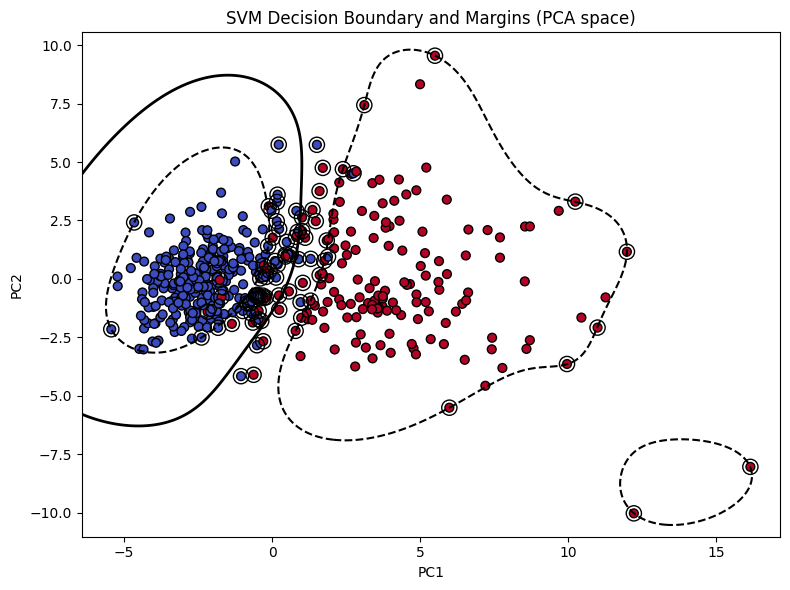

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# Numeric target for plotting colors
y_numeric = (y_train == "Malignant").astype(int)

# Train SVM on 2D PCA data
model = svm.SVC(kernel='rbf', degree=1, C=1.0)
model.fit(X_train_pca[:,[0,1]], y_train)

# Create grid
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)

# Decision values
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# --- Plot ---
plt.figure(figsize=(8,6))

plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=y_numeric,
    cmap="coolwarm",
    s=40,
    edgecolors='k'
)

# Decision boundary + margins
plt.contour(xx, yy, Z, colors='k', levels=[0], linewidths=2)
plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], linestyles='--')

# Support vectors
plt.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=120,
    facecolors='none',
    edgecolors='k'
)

plt.title("SVM Decision Boundary and Margins (PCA space)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


## 3. Hyperparameters tunning

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, recall_score

# Pipeline: scaling + SVM
pipe = Pipeline([
    ("svm", SVC())
])

# Scoring dictionary
scoring = {
    "accuracy": "accuracy",
    "recall": make_scorer(recall_score, pos_label="Malignant")
}

# PARAM GRID:
param_grid = [
    # ------ Linear ------
    {
        "svm__kernel": ["linear"],
        "svm__C": [0.001, 0.01, 0.1, 1, 10]
    },
    # ------ RBF ------
    {
        "svm__kernel": ["rbf"],
        "svm__C": [0.01, 0.1, 1, 10, 100],
        "svm__gamma": ["scale", 0.01, 0.1, 1]
    },
    # ------ Polynomial ------
    {
        "svm__kernel": ["poly"],
        "svm__degree": [2],
        "svm__C": [0.01, 0.1, 1, 10],
        "svm__gamma": ["scale", 0.01, 0.1]
    }
]

# GRID SEARCH
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=30,
    scoring=scoring,
    refit="recall",   # optimize Recall (priority in medical contexts)
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_scaled, y_train)

print("\nBest parameters:")
print(grid.best_params_)

print("\nBest Recall:", grid.best_score_)


Fitting 30 folds for each of 37 candidates, totalling 1110 fits

Best parameters:
{'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}

Best Recall: 0.9544444444444445


Best parameters:
{'svm__C': 0.01, 'svm__degree': 2, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}

Best Recall: 0.9533333333333335

## 4. SVM function

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, recall_score, roc_auc_score
import numpy as np

def svm_cross_validation(X, y,
                         kernel='poly',
                         C=0.01,
                         gamma=0.1,
                         probability=True,
                         degree = 2,
                         k=5):
    """
    Perform K-fold cross-validation for an SVM model.

    Parameters:
        X, y : numpy arrays
        kernel : 'rbf', 'linear', 'poly', etc.
        C : regularization parameter
        gamma : kernel coefficient
        probability : whether to enable predict_proba
        k : number of folds

    Returns:
        metrics (dict): mean and std of accuracy, f1, recall, AUC
        all_preds (array): predictions concatenated for all folds
    """

    # If labels are strings ('Malignant', 'Benign'), convert to numeric
    if y.dtype == object or isinstance(y[0], str):
        y = np.where(y == "Malignant", 1, 0)

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    accuracies, f1s, recalls, aucs = [], [], [], []
    all_preds = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"🔹 Fold {fold+1}/{k}")

        # ---- SPLIT ----
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]


        # ---- DEFINE SVM ----
        svm = SVC(
            kernel=kernel,
            C=C,
            gamma=gamma,
            degree=degree,
            probability=probability     # needed for AUC
        )

        # ---- TRAIN ----
        svm.fit(X_train, y_train)

        # ---- PREDICT ----
        y_pred = svm.predict(X_val)
        y_proba = svm.predict_proba(X_val)[:, 1]

        # ---- METRICS ----
        accuracies.append(accuracy_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred, pos_label=1))
        recalls.append(recall_score(y_val, y_pred, pos_label=1))
        aucs.append(roc_auc_score(y_val, y_proba))

        all_preds.extend(y_pred)

    # ---- AGGREGATE METRICS ----
    metrics = {
        "accuracy_mean": np.mean(accuracies),
        "accuracy_std": np.std(accuracies),
        "f1_mean": np.mean(f1s),
        "f1_std": np.std(f1s),
        "recall_mean": np.mean(recalls),
        "recall_std": np.std(recalls),
        "auc_mean": np.mean(aucs),
        "auc_std": np.std(aucs),
    }

    return metrics, np.array(all_preds)


In [13]:
metrics_svm, preds_svm = svm_cross_validation(
    X_train_scaled,
    y_train,
    k=30
)

print(metrics_svm)

🔹 Fold 1/30
🔹 Fold 2/30
🔹 Fold 3/30
🔹 Fold 4/30
🔹 Fold 5/30
🔹 Fold 6/30
🔹 Fold 7/30
🔹 Fold 8/30
🔹 Fold 9/30
🔹 Fold 10/30
🔹 Fold 11/30
🔹 Fold 12/30
🔹 Fold 13/30
🔹 Fold 14/30
🔹 Fold 15/30
🔹 Fold 16/30
🔹 Fold 17/30
🔹 Fold 18/30
🔹 Fold 19/30
🔹 Fold 20/30
🔹 Fold 21/30
🔹 Fold 22/30
🔹 Fold 23/30
🔹 Fold 24/30
🔹 Fold 25/30
🔹 Fold 26/30
🔹 Fold 27/30
🔹 Fold 28/30
🔹 Fold 29/30
🔹 Fold 30/30
{'accuracy_mean': np.float64(0.7141666666666668), 'accuracy_std': np.float64(0.1381240049402737), 'f1_mean': np.float64(0.3453968253968254), 'f1_std': np.float64(0.2692473544941053), 'recall_mean': np.float64(0.24477873977873982), 'recall_std': np.float64(0.22718416869745625), 'auc_mean': np.float64(0.7402061187269522), 'auc_std': np.float64(0.22063752247776677)}
